### (I) Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go # this is used for interactivate plot
import plotly.express as px

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignore tf warning

Using TensorFlow backend.


In [4]:
# Create the business day, which is used to convert the day index to stock trading days
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
B_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # business day

## (II) Data download and Exploration

In [5]:
def download_stock_to_df(symbol, start, end):
    """
    Get current stocks data from yahoo fiance and save to dataframe

    Params:
        symbol: stock to pull data
        start: start date of pulled data
        end: end date of pulled data

    Return:
        dataframe of stock within specified date range
    """
    df_stock=yf.download(symbol,start,end,progress=False)
    df_stock.reset_index(level=0, inplace=True)
    return df_stock

In [6]:
apple_stock = download_stock_to_df('AAPL', '2000-01-01', '2020-05-31')
apple_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.460857,133949200
1,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.169071,128094400
2,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.215448,194580400
3,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.937188,191993200
4,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.076317,115183600


In [7]:
print('Total data points: {}'.format(len(apple_stock)))
print('From {} to {}'.format(apple_stock['Date'].iloc[0], apple_stock['Date'].iloc[-1]))

Total data points: 5134
From 2000-01-03 00:00:00 to 2020-05-29 00:00:00


In [8]:
apple_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5.134000e+03
mean,64.154592,64.803741,63.514898,64.184123,60.260955,1.135283e+08
std,72.004205,72.762315,71.358150,72.106102,70.781017,9.831566e+07
min,0.927857,0.942143,0.908571,0.937143,0.811282,9.835000e+06
25%,5.160000,5.238929,5.068572,5.137500,4.447520,4.634312e+07
50%,32.162857,32.317856,31.890714,32.167143,27.847013,8.562260e+07
75%,104.972500,106.052500,104.485003,105.250002,97.635321,1.501342e+08
max,324.739990,327.850006,323.350006,327.200012,326.316681,1.855410e+09


## (III) Exploratory Visualization

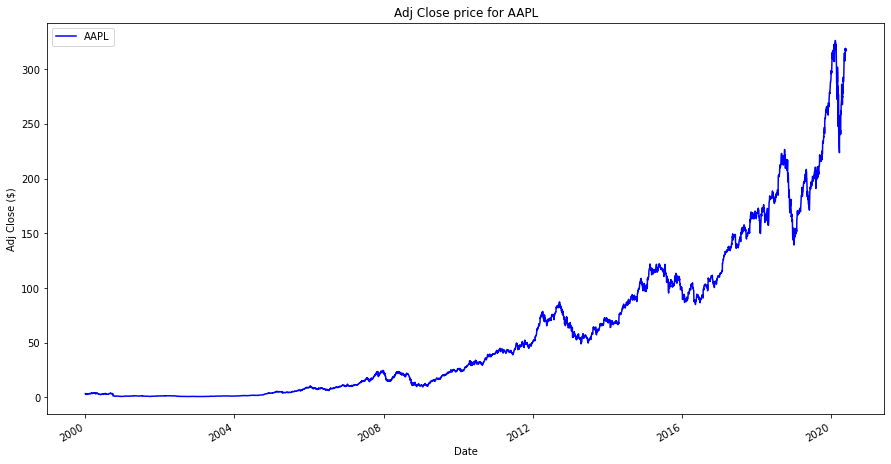

In [9]:
ax = apple_stock.plot(x='Date', y='Adj Close', title='Adj Close price for AAPL', figsize=(15, 8), color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Adj Close ($)')
ax.legend(['AAPL'])
plt.show()

There are four peaks occured after 2010: (1) 2012/07-2012/09; (2)2015/04; (3)2018/09; (4) 2020/02

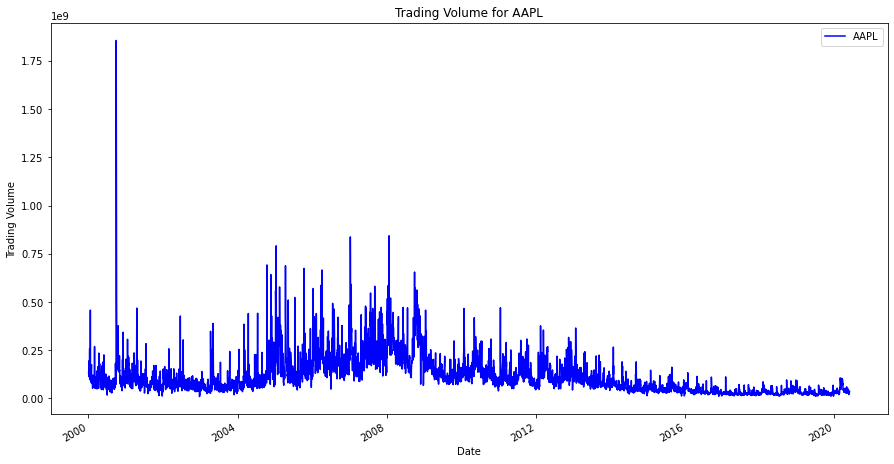

In [10]:
ax = apple_stock.plot(x='Date', y='Volume', title='Trading Volume for AAPL', figsize=(15, 8), color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Trading Volume')
ax.legend(['AAPL'])
plt.show()

In [11]:
apple_stock[apple_stock['Volume'] == apple_stock['Volume'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
188,2000-09-29,2.013393,2.071429,1.8125,1.839286,1.592265,1855410200


* **Apple's Worest Day Ever** On September 29th, 2000, AAPL saw a massive one-day drop of 51.89%. The stock's steep decline was due to a number of factors, which in hindsight combined to form a perfect storm of headwinds that proved too fierce for shareholders to deal with at the time [news link](https://www.dividend.com/how-to-invest/apples-worst-day-ever-aapl/#:~:text=September%2029%2C%202000%3A%20Apple%20Drops,deal%20with%20at%20the%20time.)

## (IV) Data Preprocessing

In [12]:
# keep only used column
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

In [13]:
df = apple_stock.copy(deep=True)

#### Normalize the data

In [14]:
sc = MinMaxScaler(feature_range=(0.01,0.99))
df['Scaled_Close'] = sc.fit_transform(df[['Adj Close']])

In [15]:
df.head()

,Date,Adj Close,Scaled_Close
0,2000-01-03,3.460857,0.017977
1,2000-01-04,3.169071,0.017099
2,2000-01-05,3.215448,0.017238
3,2000-01-06,2.937188,0.016400
4,2000-01-07,3.076317,0.016819


#### Define the model training and test set

In [16]:
# we will test/validate on 40 periods (if forcast is seven days, then 40x7=280 days)
num_periods = 40
forcast_days = 15
lookback_days = 30
window_size  = 15

In [17]:
N = df.shape[0]
N_test = num_periods*forcast_days
N_train = N - N_test

In [18]:
from sklearn.model_selection import train_test_split
dataset_train , dataset_test = train_test_split(df, train_size=N_train, test_size=N_test, shuffle=False)

In [19]:
dataset_test_extend = dataset_train[-lookback_days:].append(dataset_test)
print(dataset_train.shape, dataset_test.shape, dataset_test_extend.shape)

(4534, 3) (600, 3) (630, 3)


In [20]:
train_set = dataset_train[['Scaled_Close']].values
test_set = dataset_test[['Scaled_Close']].values

In [21]:
# extend the test set to add some previous information
test_set_extend = dataset_test_extend[['Scaled_Close']].values
print(train_set.shape, test_set.shape, test_set_extend.shape)

(4534, 1) (600, 1) (630, 1)


In [22]:
dataset_test.head()

,Date,Adj Close,Scaled_Close
4534,2018-01-10,168.314102,0.514301
4535,2018-01-11,169.270157,0.517180
4536,2018-01-12,171.018112,0.522442
4537,2018-01-16,170.148972,0.519825
4538,2018-01-17,172.959213,0.528286


## LSTM Training

#### Create sequence for training

In [23]:
dataset_train.head()

,Date,Adj Close,Scaled_Close
0,2000-01-03,3.460857,0.017977
1,2000-01-04,3.169071,0.017099
2,2000-01-05,3.215448,0.017238
3,2000-01-06,2.937188,0.016400
4,2000-01-07,3.076317,0.016819


In [24]:
# train sequence is continuous
def generate_train_sequence(train_data, lookback_days, forcast_days):
    """
    Generate sequence array for train data,
    inclduing both X and y
    """
    X = []
    y = []
    m = lookback_days
    n =forcast_days
    N = len(train_data)
    
    for i in range(0, N, 1):
        # input sequence : x[i].....x[i+m]
        # output sequence: x[i+m+1]....x[i+m+n] 
        # last index is (i+m+n)
        end_index = i + m + n # find the end of this sequence
        # check if we are out of index
        if end_index > N-1:
            break
        seq_x = train_data[i:(i+m)]
        seq_y = train_data[(i+m):(i+m+n)]
        X.append(seq_x)
        y.append(seq_y)
        
    array_X = np.array(X) # shape (N, m, 1)
    array_y = np.array([list(a.ravel()) for a in np.array(y)]) # shape (N, n, 1) convert to (N, n)
    return array_X, array_y

In [25]:
X_train, y_train = generate_train_sequence(train_set, lookback_days, forcast_days)
print(X_train.shape, y_train.shape)

(4489, 30, 1) (4489, 15)


In [26]:
print(X_train[0])
print(' ')
print(y_train[0])

[[0.01797708]
 [0.0170986 ]
 [0.01723823]
 [0.01640047]
 [0.01681935]
 [0.01665645]
 [0.01619103]
 [0.01567325]
 [0.01656337]
 [0.01690661]
 [0.01723241]
 [0.01747675]
 [0.01812253]
 [0.0179189 ]
 [0.01744766]
 [0.01800617]
 [0.01781418]
 [0.01779673]
 [0.01701715]
 [0.01721496]
 [0.01688916]
 [0.01675535]
 [0.01717423]
 [0.01761056]
 [0.01817489]
 [0.01825052]
 [0.01804108]
 [0.01812253]
 [0.01768038]
 [0.01833778]]
 
[0.01863449 0.01818071 0.01825052 0.01791309 0.01815162 0.01837851
 0.01828106 0.01783164 0.01809926 0.01822725 0.01968751 0.01891374
 0.01947225 0.01925699 0.01899519]


## LSTM model implementation

In [27]:
model = Sequential()
model.add(LSTM(units=30, activation='relu', input_shape=(lookback_days,1)))
model.add(Dense(forcast_days))
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
Total params: 4,305
Trainable params: 4,305
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 300
history  = model.fit(X_train,y_train,epochs=num_epochs,batch_size=32)

Epoch 1/300
4489/4489 [==============================] - 2s 546us/step - loss: 0.0127
Epoch 2/300
4489/4489 [==============================] - 2s 441us/step - loss: 1.1232e-04
Epoch 3/300
4489/4489 [==============================] - 2s 440us/step - loss: 9.9661e-05
Epoch 4/300
4489/4489 [==============================] - 2s 432us/step - loss: 9.3066e-05
Epoch 5/300
4489/4489 [==============================] - 2s 450us/step - loss: 8.9001e-05
Epoch 6/300
4489/4489 [==============================] - 2s 431us/step - loss: 8.6187e-05
Epoch 7/300
4489/4489 [==============================] - 2s 461us/step - loss: 8.9962e-05
Epoch 8/300
4489/4489 [==============================] - 2s 446us/step - loss: 9.9071e-05
Epoch 9/300
4489/4489 [==============================] - 2s 441us/step - loss: 7.9777e-05
Epoch 10/300
4489/4489 [==============================] - 2s 449us/step - loss: 8.2293e-05
Epoch 11/300
4489/4489 [==============================] - 2s 434us/step - loss: 7.9728e-05
Epoch 12/300

4489/4489 [==============================] - 2s 434us/step - loss: 6.0213e-05
Epoch 91/300
4489/4489 [==============================] - 2s 450us/step - loss: 6.1367e-05
Epoch 92/300
4489/4489 [==============================] - 2s 438us/step - loss: 5.8679e-05
Epoch 93/300
4489/4489 [==============================] - 2s 432us/step - loss: 6.1645e-05
Epoch 94/300
4489/4489 [==============================] - 2s 451us/step - loss: 6.3156e-05
Epoch 95/300
4489/4489 [==============================] - 2s 471us/step - loss: 6.1360e-05
Epoch 96/300
4489/4489 [==============================] - 2s 465us/step - loss: 5.9144e-05 
Epoch 97/300
4489/4489 [==============================] - 2s 505us/step - loss: 5.9942e-05
Epoch 98/300
4489/4489 [==============================] - 2s 455us/step - loss: 5.9008e-05
Epoch 99/300
4489/4489 [==============================] - 2s 459us/step - loss: 5.8535e-05
Epoch 100/300
4489/4489 [==============================] - 2s 473us/step - loss: 5.8560e-05 1s - loss:

4489/4489 [==============================] - 2s 449us/step - loss: 5.8564e-05
Epoch 179/300
4489/4489 [==============================] - 2s 433us/step - loss: 5.7938e-05
Epoch 180/300
4489/4489 [==============================] - 2s 441us/step - loss: 5.8186e-05
Epoch 181/300
4489/4489 [==============================] - 2s 434us/step - loss: 5.6879e-05
Epoch 182/300
4489/4489 [==============================] - 2s 441us/step - loss: 5.8589e-05
Epoch 183/300
4489/4489 [==============================] - 2s 442us/step - loss: 6.2171e-05
Epoch 184/300
4489/4489 [==============================] - 2s 433us/step - loss: 5.7895e-05
Epoch 185/300
4489/4489 [==============================] - 2s 439us/step - loss: 5.8761e-05
Epoch 186/300
4489/4489 [==============================] - 2s 436us/step - loss: 5.6291e-05
Epoch 187/300
4489/4489 [==============================] - 2s 462us/step - loss: 5.7718e-05
Epoch 188/300
4489/4489 [==============================] - 2s 466us/step - loss: 5.7050e-05
Ep

4489/4489 [==============================] - 3s 603us/step - loss: 5.7958e-05
Epoch 267/300
4489/4489 [==============================] - 3s 592us/step - loss: 5.7852e-05
Epoch 268/300
4489/4489 [==============================] - 3s 605us/step - loss: 5.7481e-05
Epoch 269/300
4489/4489 [==============================] - 3s 638us/step - loss: 5.7345e-05
Epoch 270/300
4489/4489 [==============================] - ETA: 0s - loss: 5.8019e-0 - 3s 579us/step - loss: 5.8173e-05
Epoch 271/300
4489/4489 [==============================] - 3s 663us/step - loss: 5.8206e-05
Epoch 272/300
4489/4489 [==============================] - 3s 611us/step - loss: 5.7210e-05
Epoch 273/300
4489/4489 [==============================] - 2s 537us/step - loss: 5.8835e-05
Epoch 274/300
4489/4489 [==============================] - 3s 646us/step - loss: 5.6005e-05 0s - l
Epoch 275/300
4489/4489 [==============================] - 3s 596us/step - loss: 5.7397e-05
Epoch 276/300
4489/4489 [==============================] - 

#### Visualize the training data

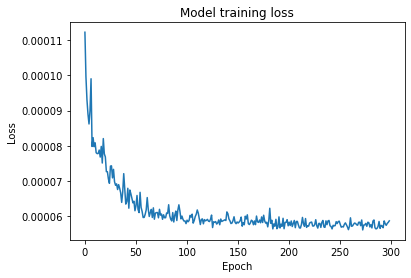

In [30]:
plt.figure()
plt.plot(history.history['loss'][1:])
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')
plt.show()

## Prediction on the test set with LSTM

In [31]:
# test sequence is not continuous, will be in 20 groups, each group contains 7 days
def generate_test_sequence(test_data, lookback_days, forcast_days):
    """
    Generate sequence array for test data,
    inclduing only X
    """
    X = []
    y = []
    m = lookback_days
    n =forcast_days
    N = len(test_data)
    
    for i in range(0, N, n): # here use 7, not 1, as we will use groups
        # input sequence : x[i].....x[i+m]
        # output sequence: x[i+m+1]....x[i+m+n] 
        # last index is (i+m+n)
        end_index = i + m + n # find the end of this sequence
        # check if we are out of index
        if end_index > N:
            break
#         print(i, i+m, i+m+n)
        seq_x = test_data[i:(i+m)]
        seq_y = test_data[(i+m):(i+m+n)]
        X.append(seq_x)
        y.append(seq_y)
        
    array_X = np.array(X) # shape (N, m, 1)
    array_y = np.array([list(a.ravel()) for a in np.array(y)]) # shape (N, n, 1) convert to (N, n)
    return array_X, array_y

In [32]:
X_test, y_test = generate_test_sequence(test_set_extend, lookback_days, forcast_days)
print(test_set_extend.shape, X_test.shape, y_test.shape)

(630, 1) (40, 30, 1) (40, 15)


In [33]:
LSTM_prediction_scaled = model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction_scaled)

train_set = train_set.reshape((-1))
test_set = test_set.reshape((-1))
LSTM_prediction = LSTM_prediction.reshape((-1))

In [34]:
dataset_test['LSTM_Prediction'] = LSTM_prediction
dataset_test.head()

,Date,Adj Close,Scaled_Close,LSTM_Prediction
4534,2018-01-10,168.314102,0.514301,169.111542
4535,2018-01-11,169.270157,0.517180,168.743607
4536,2018-01-12,171.018112,0.522442,169.605255
4537,2018-01-16,170.148972,0.519825,168.627579
4538,2018-01-17,172.959213,0.528286,168.779510


In [35]:
def plot_prediction_comparison(true_set, prediction_set):
    plt.figure(figsize = (15,8))

    for i in range(0, len(prediction_set), forcast_days):
        indexs = [i+x for x in range(forcast_days)]
        values = prediction_set[i:i+forcast_days]
        plt.plot(indexs, values, color='r')

    plt.plot(0, prediction_set[0], color='r', label='prediction') # just used to add label

    plt.plot(true_set, color='b', label='True Close')
    plt.legend(loc='best')
    plt.show()

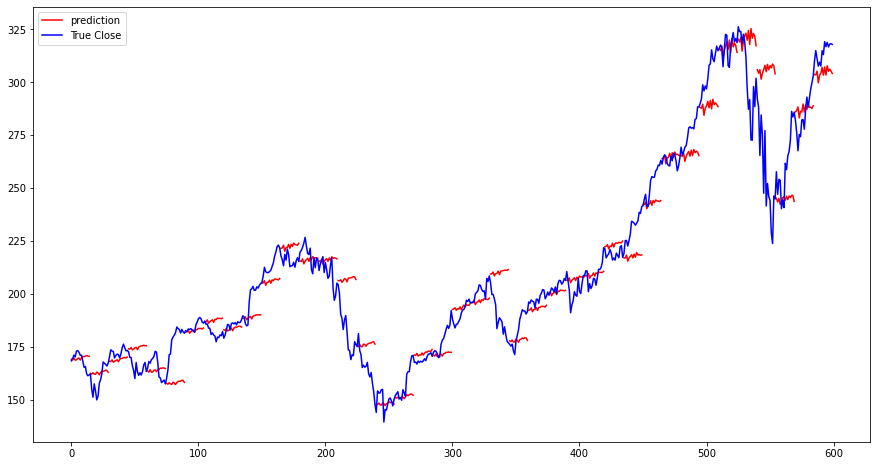

In [36]:
plot_prediction_comparison(dataset_test['Adj Close'].values, dataset_test['LSTM_Prediction'].values)

## Moving Average

In [37]:
dataset_test_extend['MA_Prediction'] = np.NaN

def make_window(size, start):
    # make index window for use of concat of real price and prediction price
    return [start+k for k in range(size)]

for index in range(window_size, len(dataset_test_extend), forcast_days):
    for i in range(0,forcast_days):
        if index+i >= len(dataset_test_extend):
            break
        # window for real price, eg [1, 2, 3, 4, 5, 6, 7, 8, 9]
        window_real = make_window(window_size-i, index+i-window_size)
        
        # window for predicted price, eg [10]
        window_MA = make_window(i, index)

        price_window = pd.concat([ dataset_test_extend['Adj Close'].iloc[window_real], 
                                   dataset_test_extend['MA_Prediction'].iloc[window_MA] ])
        next_mean_prediction = price_window.mean(axis=0)

        dataset_test_extend.iat[index+i, dataset_test_extend.columns.get_loc('MA_Prediction')] = next_mean_prediction

In [38]:
dataset_test['MA_Prediction'] = dataset_test_extend[lookback_days:]['MA_Prediction'].values
dataset_test.head()

,Date,Adj Close,Scaled_Close,LSTM_Prediction,MA_Prediction
4534,2018-01-10,168.314102,0.514301,169.111542,166.344694
4535,2018-01-11,169.270157,0.517180,168.743607,166.285485
4536,2018-01-12,171.018112,0.522442,169.605255,166.257137
4537,2018-01-16,170.148972,0.519825,168.627579,166.343406
4538,2018-01-17,172.959213,0.528286,168.779510,166.356260


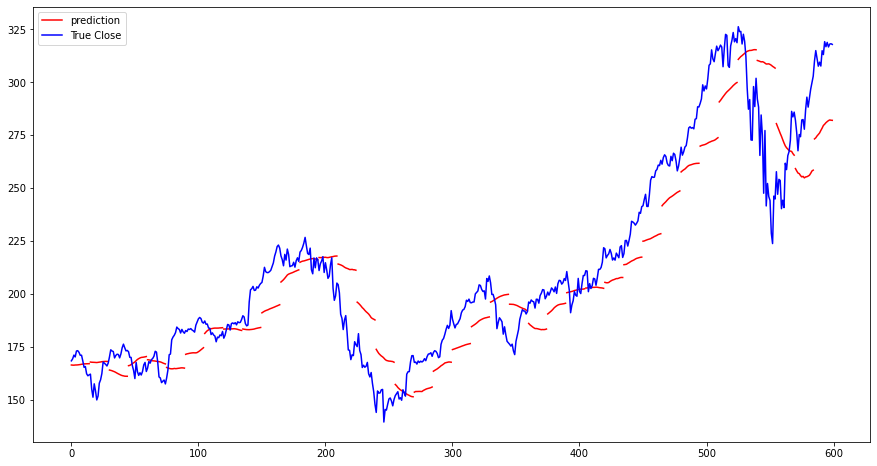

In [39]:
plot_prediction_comparison(dataset_test['Adj Close'].values, dataset_test['MA_Prediction'].values)

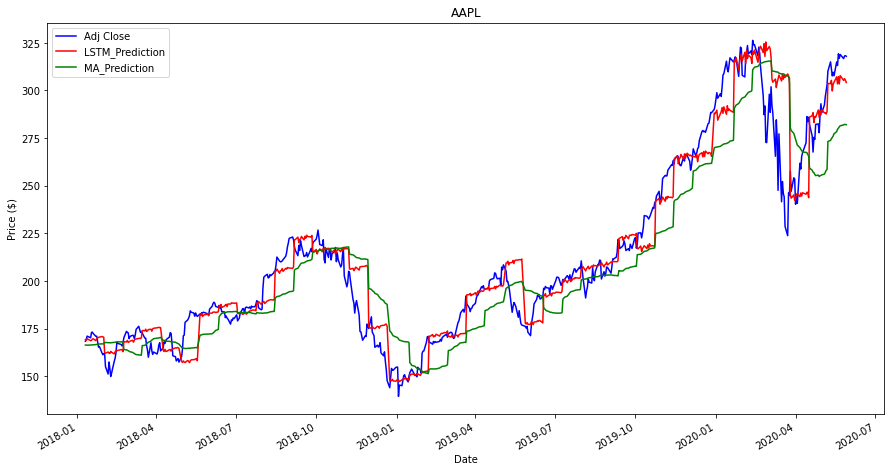

In [40]:
ax = dataset_test.plot(x='Date', y=["Adj Close", "LSTM_Prediction", "MA_Prediction"], 
                       title='AAPL', figsize=(15, 8), color=['blue', 'red', 'green'])

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
plt.show()

## Evaludate the performance

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# metrics.mean_absolute_error(y_test, y_pred)

def evaluate_prediction(y_true, y_pred):
    
    # mean absolute error
    mae = mean_absolute_error(y_true, y_pred)
    
    #mean squared error
    mse = mean_squared_error(y_true, y_pred)
    
    # root mean squared error
    rmse = round(np.sqrt(mse), 2)
    
    # mean absolute percentage error
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)
           
    return {'root_mean_squared_error': rmse, 
            'mean_absolute_percentage_error': mape}


In [42]:
y_test = dataset_test['Adj Close']
y_pred_lstm = dataset_test['LSTM_Prediction']
y_pred_ma = dataset_test['MA_Prediction']

In [43]:
# evaluation for LSTM prediction
evaluate_prediction(y_test, y_pred_lstm)

{'root_mean_squared_error': 14.2, 'mean_absolute_percentage_error': 4.34}

In [44]:
# evaluation for Moving Average prediction
evaluate_prediction(y_test, y_pred_ma)

{'root_mean_squared_error': 19.39, 'mean_absolute_percentage_error': 7.04}

## Forcast

In [45]:
df.tail()

,Date,Adj Close,Scaled_Close
5129,2020-05-22,318.890015,0.967641
5130,2020-05-26,316.730011,0.961137
5131,2020-05-27,318.109985,0.965292
5132,2020-05-28,318.250000,0.965714
5133,2020-05-29,317.940002,0.964780


In [46]:
def predict_future_price(df, lookback_days, forcast_days, model, sc):
    """
    Prediction of future stock price
    """
    
    # calculate forcast dates and indexs, used for plot
    B_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # business day
    forcast_dates = [df['Date'].iloc[-1]+i*B_DAY for i in range(1,forcast_days+1)]
    forcast_indexs = [df['Date'].index[-1]+i for i in range(1,forcast_days+1)]
    
    # input X for forcast
    X_scaled = df[['Scaled_Close']][-lookback_days:].values
    X_scaled = X_scaled.reshape((1, lookback_days, 1))
    
    # prediction the scaled price with model
    forcast_price_scaled = model.predict(X_scaled)
    
    # transform back to the normal price
    forcast_prices = sc.inverse_transform(forcast_price_scaled)
    
    # create the forcast_dataframe
    forcast_dataframe = pd.DataFrame({
        'index' : forcast_indexs,
        'Date' : forcast_dates,
        'Adj Close' : forcast_prices[0],
        'Scaled_Close' : forcast_price_scaled[0]
    })

    forcast_dataframe = forcast_dataframe.set_index('index', drop=True)
    return forcast_dataframe

In [47]:
dataset_forcast = predict_future_price(df, lookback_days, forcast_days, model, sc)

In [48]:
dataset_forcast

,Date,Adj Close,Scaled_Close
index,,,
5134,2020-06-01,320.325165,0.971961
5135,2020-06-02,319.219971,0.968634
5136,2020-06-03,321.196075,0.974583
5137,2020-06-04,314.967712,0.955832
5138,2020-06-05,319.358612,0.969051
5139,2020-06-08,321.964935,0.976898
5140,2020-06-09,323.240784,0.980739
5141,2020-06-10,319.864075,0.970573
5142,2020-06-11,324.488831,0.984497


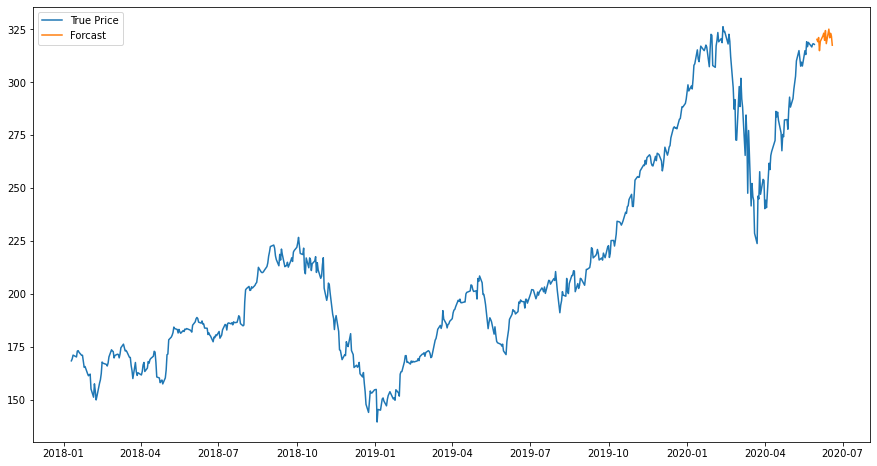

In [49]:
fig = plt.figure(figsize = (15,8))

for frame in [dataset_test, dataset_forcast]:
    plt.plot(frame['Date'], frame['Adj Close'])

plt.legend(['True Price', 'Forcast'], loc='upper left')
plt.show()